In [1]:
# Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# API url to extract the data from
url = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'

In [3]:
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36'
    ,'accept-encoding': 'gzip, deflate, br'
    ,'accept-language': 'en-US,en;q=0.9'    
}

In [4]:
# Create a session and send request to get the data from the website
session = requests.Session()
request = session.get(url, headers=headers)
cookies = dict(request.cookies)
response = session.get(url, headers=headers, cookies=cookies).json()
rawdata = pd.DataFrame(response)

In [5]:
# Check the data structure of the raw data
rawdata

,records,filtered
expiryDates,"[03-Feb-2022, 10-Feb-2022, 17-Feb-2022, 24-Feb...",NaN
data,"[{'strikePrice': 7500, 'expiryDate': '29-Dec-2...","[{'strikePrice': 15100, 'expiryDate': '03-Feb-..."
timestamp,28-Jan-2022 15:30:00,NaN
underlyingValue,17102,NaN
strikePrices,"[7500, 8300, 8500, 8700, 9000, 9500, 9700, 990...",NaN
CE,NaN,"{'totOI': 998045, 'totVol': 4367521}"
PE,NaN,"{'totOI': 600564, 'totVol': 3263684}"


In [6]:
# Take the required cell into a dataframe to work on it
df= pd.DataFrame(response["records"]['data']).fillna(0)

In [7]:
# Check the structure of the underlying dataframe
df

,strikePrice,expiryDate,PE,CE
0,7500,29-Dec-2022,"{'strikePrice': 7500, 'expiryDate': '29-Dec-20...",0
1,8300,30-Jun-2022,"{'strikePrice': 8300, 'expiryDate': '30-Jun-20...",0
2,8500,29-Jun-2023,0,"{'strikePrice': 8500, 'expiryDate': '29-Jun-20..."
3,8500,29-Dec-2022,"{'strikePrice': 8500, 'expiryDate': '29-Dec-20...",0
4,8700,29-Dec-2022,"{'strikePrice': 8700, 'expiryDate': '29-Dec-20...",0
...,...,...,...,...
1004,23000,26-Dec-2024,"{'strikePrice': 23000, 'expiryDate': '26-Dec-2...","{'strikePrice': 23000, 'expiryDate': '26-Dec-2..."
1005,23000,26-Jun-2025,"{'strikePrice': 23000, 'expiryDate': '26-Jun-2...","{'strikePrice': 23000, 'expiryDate': '26-Jun-2..."
1006,23000,24-Dec-2025,"{'strikePrice': 23000, 'expiryDate': '24-Dec-2...","{'strikePrice': 23000, 'expiryDate': '24-Dec-2..."
1007,23000,25-Jun-2026,"{'strikePrice': 23000, 'expiryDate': '25-Jun-2...","{'strikePrice': 23000, 'expiryDate': '25-Jun-2..."


In [8]:
# Convert the dataframe from a dict structure into a data frame structure
def option_dataframe(df):
    data = []
    for i in range(len(df)):
        call_oi = call_coi = put_oi = put_coi  = int(0)
        call_IV = put_IV = call_ltp = put_ltp = float(0)
        strike = df.iloc[i,0]
        expiry = df.iloc[i,1]
        if(df.iloc[i,-1] == 0):
            calloi = call_coi = 0
        else:
            call_oi = df.iloc[i,-1]["openInterest"]
            call_coi = df.iloc[i,-1]["changeinOpenInterest"]
            call_ltp = df.iloc[i,-1]['lastPrice']
            call_IV = df.iloc[i,-1]['impliedVolatility']
        
        if(df.iloc[i,-2] == 0):
            putoi = put_coi = 0
        else:
            put_oi = df.iloc[i,-2]["openInterest"]
            put_coi = df.iloc[i,-2]["changeinOpenInterest"]
            put_ltp = df.iloc[i,-2]['lastPrice']
            put_IV = df.iloc[i,-2]['impliedVolatility']
            
        option_data = {"Expiry": expiry,
            "Call OI" : call_oi, "Call C_OI" : call_coi,"Call IV": call_IV ,"Call LTP" : call_ltp, "Strike" : strike,
             "Put LTP" : put_ltp ,"Put IV" : put_IV , "Put C_OI" : put_coi, "Put OI" : put_oi
        }
        data.append(option_data)
    optionchain = pd.DataFrame(data)

    return optionchain , df.iloc[0,-2]["underlyingValue"]

In [9]:
# Create an instance of the function by calling it
optionchain  , underlying_ltp = option_dataframe(df) 

In [10]:
# Check the Last traded price of the underlying security
underlying_ltp

17101.95

In [11]:
# Check the dataframe contating the options data
optionchain

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,Strike,Put LTP,Put IV,Put C_OI,Put OI
0,29-Dec-2022,0.0,0.0,0.0,0.0,7500,0.0,0.0,0,21.0
1,30-Jun-2022,0.0,0.0,0.0,0.0,8300,0.0,0.0,0,3.0
2,29-Jun-2023,319.5,0.0,0.0,0.0,8500,0.0,0.0,0,0.0
3,29-Dec-2022,0.0,0.0,0.0,0.0,8500,0.0,0.0,0,2254.0
4,29-Dec-2022,0.0,0.0,0.0,0.0,8700,0.0,0.0,0,2250.0
...,...,...,...,...,...,...,...,...,...,...
1004,26-Dec-2024,0.0,0.0,0.0,0.0,23000,0.0,0.0,0,0.0
1005,26-Jun-2025,0.0,0.0,0.0,0.0,23000,0.0,0.0,0,0.0
1006,24-Dec-2025,0.0,0.0,0.0,0.0,23000,0.0,0.0,0,0.0
1007,25-Jun-2026,0.0,0.0,0.0,0.0,23000,0.0,0.0,0,0.0


In [12]:
# Create a list of strike prices and expires sorted in ascending order
strike_list = pd.Series(optionchain["Strike"].unique()).sort_values(ascending=True)
expiries_list = pd.to_datetime(optionchain["Expiry"].unique()).sort_values(ascending=True)

In [13]:
# Create a dictionary contaitng all the data sorted by the expiry
def by_expiry(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Expiry", "Strike"], ascending=True, inplace=True)
    option_dict = {}
    optionchain["Expiry"] = pd.to_datetime(optionchain["Expiry"])
    for i in  range(len(expiries_list)):
        option_dict[i] = optionchain.loc[optionchain["Expiry"] == expiries_list[i]]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Expiry"], axis=1, inplace=True)
    return option_dict

In [14]:
# Create another dictionary contaitng all the data sorted by the strikes
def by_strike(optionchain, cutoff = 50):
    optionchain.sort_values(by=["Strike","Expiry"], inplace=True, ascending=True)
    option_dict = {}
    for i in  strike_list:
        option_dict[i] = optionchain.loc[optionchain["Strike"] == i]
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call OI"]<=cutoff) | (option_dict[i]["Put OI"]<=cutoff)].index)
        option_dict[i] = option_dict[i].drop(option_dict[i][(option_dict[i]["Call LTP"] == 0) | (option_dict[i]["Put LTP"] == 0)].index)
        option_dict[i].reset_index(inplace=True,drop=True)
        option_dict[i].drop(["Strike"], axis=1, inplace=True)
    return option_dict

In [15]:
expiry = by_expiry(optionchain, cutoff = 100)
strike = by_strike(optionchain, cutoff = 100)

In [16]:
# Check whether the expiry dictionary contains the data in the required format
expiry[0]

,Call OI,Call C_OI,Call IV,Call LTP,Strike,Put LTP,Put IV,Put C_OI,Put OI
0,362.0,9.0,86.88,1810.00,15500,4.50,36.56,23174,48115.0
1,1517.0,-392.0,77.00,1364.65,16000,9.60,29.96,11243,39842.0
2,103.0,46.0,66.29,1073.90,16300,17.75,26.38,7051,14713.0
3,1278.0,-5.0,63.93,1021.70,16350,19.90,25.81,1128,2152.0
4,1833.0,208.0,58.84,880.70,16500,29.00,24.26,16980,45729.0
5,715.0,-126.0,55.38,787.40,16600,37.50,23.22,5061,25264.0
6,148.0,-12.0,52.11,729.05,16650,42.70,22.69,2516,3522.0
7,713.0,-134.0,52.49,700.00,16700,48.80,22.19,27482,34368.0
8,164.0,-14.0,51.99,664.60,16750,56.00,21.71,2238,3259.0
9,1584.0,-26.0,49.89,616.75,16800,64.00,21.20,15571,26078.0


In [17]:
# Check whether the strike dictionary actually contains data in the required form
strike[17100]

,Expiry,Call OI,Call C_OI,Call IV,Call LTP,Put LTP,Put IV,Put C_OI,Put OI
0,2022-02-03,20114.0,5166.0,43.16,392.40,138.80,17.55,9585,22954.0
1,2022-02-10,899.0,-36.0,33.84,466.90,203.75,18.19,541,1213.0
2,2022-02-24,6257.0,-133.0,25.33,534.90,267.80,17.73,1583,13006.0
3,2022-03-31,211.0,53.0,20.08,716.55,382.45,18.46,282,951.0


In [18]:
# Define a function to plot the Skew of call and put options for a given expiry 
def plot_graph_expiry(options, expiry=0):
    plt.plot(options[expiry]["Strike"],options[expiry]["Call IV"])
    plt.plot(options[expiry]["Strike"],options[expiry]["Put IV"], color='r')#, figure=(20,16)
    plt.grid('True')
    plt.title("Option Skew")
    plt.xlabel("Strikes")
    plt.legend(["Call Skew","Put Skew"])
    plt.ylabel("Implied Volatility")
    plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

In [19]:
# Define a function to plot the term structure of a particular strike 
def plot_graph_strike(option, strike=17100):
    option[strike]["Expiry"] = pd.to_datetime(option[strike]["Expiry"])
    plt.plot(option[strike]["Expiry"], option[strike]["Call IV"])
    plt.plot(option[strike]["Expiry"], option[strike]["Put IV"], color = 'r')
    plt.grid('True')
    plt.title("Term Structure of " + str(strike) + " option.")
    plt.legend(["Call Term Structure","Put Term Structure"])
    plt.ylabel("Implied Volatility")
#     plt.axvline(x=underlying_ltp, color = 'r', linestyle = '--')
    plt.show();

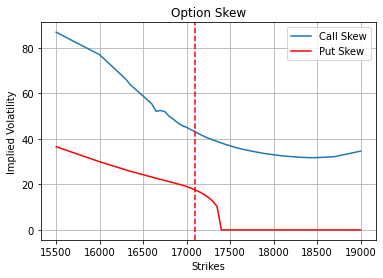

In [20]:
plot_graph_expiry(expiry, 0)

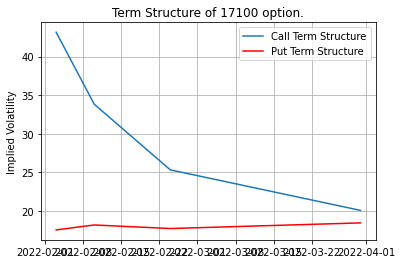

In [21]:
plot_graph_strike(strike, 17100)